In [1]:
import pandas as pd
import numpy as np
from alpha_vantage.timeseries import TimeSeries
import requests
import quandl
import matplotlib.pyplot as plt

In [2]:
ALPHA_VANTAGE_API_KEY = "6JKWIK2RFT5121M1"

ts = TimeSeries(key=ALPHA_VANTAGE_API_KEY, output_format="pandas")

In [14]:
data, meta_data = ts.get_daily(
    symbol="VOT",
    outputsize="full" #  returns full history (compact = last 100 days)
)

data = data.reset_index()
data = data.rename(columns={
    "date": "Date",
    "1. open": "Open",
    "2. high": "High",
    "3. low": "Low",
    "4. close": "Close",
    "5. volume": "Volume"
})

data = data.sort_values(by="Date")
data = data.reset_index()
data = data.drop(columns=["index"])

data["50_day_MA"] = data["Close"].rolling(window=50).mean() # 50-days Moving average
data["100_day_MA"] = data["Close"].rolling(window=100).mean() # 100-days Moving average
data["Log_return"] = np.log(data["Close"] / data["Close"].shift(1)) # Daily log returns
# Annualized daily volatility computed from rolling standard deviation of 20 days 
data["Volatility"] = data["Log_return"].rolling(window=20).std() * np.sqrt(252)  


ten_years_ago = pd.Timestamp.today() - pd.DateOffset(years=10)
data = data[data["Date"] >= ten_years_ago]

data

,Date,Open,High,Low,Close,Volume,50_day_MA,100_day_MA,Log_return,Volatility
2238,2015-07-20,108.65,108.7800,108.2900,108.57,76179.0,108.0556,107.873341,0.001475,0.142507
2239,2015-07-21,108.53,108.7320,107.8501,108.04,101836.0,108.0508,107.885441,-0.004894,0.142441
2240,2015-07-22,107.53,108.2500,107.5300,108.09,113242.0,108.0538,107.899641,0.000463,0.142495
2241,2015-07-23,108.40,108.8299,107.6600,107.82,123288.0,108.0538,107.900641,-0.002501,0.138486
2242,2015-07-24,107.67,107.8400,106.3900,106.69,227419.0,108.0344,107.895741,-0.010536,0.143057
...,...,...,...,...,...,...,...,...,...,...
4748,2025-07-14,283.60,286.4199,283.2801,285.80,183893.0,271.7440,258.526800,0.008856,0.125560
4749,2025-07-15,286.65,286.6500,283.0600,283.13,224102.0,272.4024,258.627700,-0.009386,0.122720
4750,2025-07-16,284.42,284.6700,280.4201,284.25,213794.0,273.0094,258.779000,0.003948,0.118212
4751,2025-07-17,284.64,287.4400,284.6400,286.62,292853.0,273.6596,259.026100,0.008303,0.113470


In [4]:
url = f"https://www.alphavantage.co/query?function=TREASURY_YIELD&interval=daily&maturity=10year&apikey={ALPHA_VANTAGE_API_KEY}"

response = requests.get(url)
risk_free_rate_data = response.json()

# At this point, the unit is percent and interval is daily
risk_free_rate_data = pd.DataFrame(risk_free_rate_data["data"])

risk_free_rate_data = risk_free_rate_data.rename(columns={
    "date": "Date",
    "value": "Value"
})

risk_free_rate_data = risk_free_rate_data.sort_values(by="Date")
risk_free_rate_data = risk_free_rate_data.reset_index()
risk_free_rate_data = risk_free_rate_data.drop(columns="index")

# This changes string values of Value column to numbers only if possible and divide by 100 to get the
# percentage values as a fraction of 1
risk_free_rate_data["Value"] = pd.to_numeric(risk_free_rate_data["Value"], errors="coerce") / 100
risk_free_rate_data["Date"] = pd.to_datetime(risk_free_rate_data["Date"], errors="coerce")

# The U.S. Department of Treasury posts rates daily on business days, however, for weekends and holidays
# the rates stay unchanged, therefore ->
# This will replace each missing value (NaN) with the most recent previous non-missing value
risk_free_rate_data["Value"] = risk_free_rate_data["Value"].ffill()

ten_years_risk_free_rate_data = risk_free_rate_data[risk_free_rate_data["Date"] >= ten_years_ago]

ten_years_risk_free_rate_data

,Date,Value
13969,2015-07-20,0.0238
13970,2015-07-21,0.0235
13971,2015-07-22,0.0233
13972,2015-07-23,0.0228
13973,2015-07-24,0.0227
...,...,...
16572,2025-07-10,0.0435
16573,2025-07-11,0.0443
16574,2025-07-14,0.0443
16575,2025-07-15,0.0450


In [15]:
merged_data = pd.merge(data, ten_years_risk_free_rate_data, on="Date", how="inner")

In [16]:
merged_data = merged_data.rename(columns={"Value": "Risk-free Rate"})
merged_data

,Date,Open,High,Low,Close,Volume,50_day_MA,100_day_MA,Log_return,Volatility,Risk-free Rate
0,2015-07-20,108.65,108.7800,108.2900,108.57,76179.0,108.0556,107.873341,0.001475,0.142507,0.0238
1,2015-07-21,108.53,108.7320,107.8501,108.04,101836.0,108.0508,107.885441,-0.004894,0.142441,0.0235
2,2015-07-22,107.53,108.2500,107.5300,108.09,113242.0,108.0538,107.899641,0.000463,0.142495,0.0233
3,2015-07-23,108.40,108.8299,107.6600,107.82,123288.0,108.0538,107.900641,-0.002501,0.138486,0.0228
4,2015-07-24,107.67,107.8400,106.3900,106.69,227419.0,108.0344,107.895741,-0.010536,0.143057,0.0227
...,...,...,...,...,...,...,...,...,...,...,...
2508,2025-07-10,286.67,286.6700,284.3478,285.53,223973.0,270.3122,258.306900,-0.004577,0.119711,0.0435
2509,2025-07-11,284.16,285.0000,283.2800,283.28,143437.0,271.0060,258.412000,-0.007911,0.123121,0.0443
2510,2025-07-14,283.60,286.4199,283.2801,285.80,183893.0,271.7440,258.526800,0.008856,0.125560,0.0443
2511,2025-07-15,286.65,286.6500,283.0600,283.13,224102.0,272.4024,258.627700,-0.009386,0.122720,0.0450


In [18]:
merged_data.to_csv("./../data/vot_data.csv")

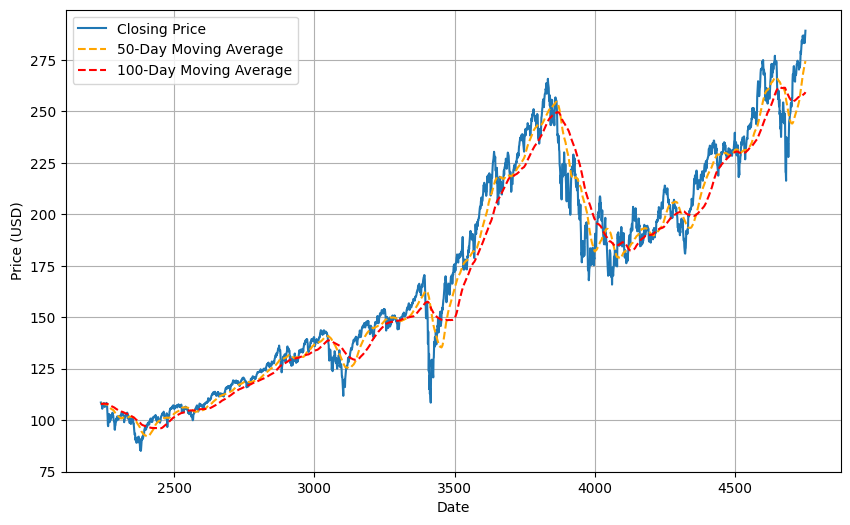

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(data["Close"], label="Closing Price")
plt.plot(data["50_day_MA"], label="50-Day Moving Average", color="orange", linestyle="--")
plt.plot(data["100_day_MA"], label="100-Day Moving Average", color="red", linestyle="--")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid()
plt.show()

In [13]:
risk_free_rate_data["Value"] = risk_free_rate_data["Value"].ffill()

risk_free_rate_data

,Date,Value
0,1962-01-02,0.0406
1,1962-01-03,0.0403
2,1962-01-04,0.0399
3,1962-01-05,0.0402
4,1962-01-08,0.0403
...,...,...
16572,2025-07-10,0.0435
16573,2025-07-11,0.0443
16574,2025-07-14,0.0443
16575,2025-07-15,0.0450
